In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from transformers import AutoImageProcessor, AutoModelForImageClassification

from PIL import Image
import matplotlib.pyplot as plt

import requests
import random


In [2]:

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/parrots.png"
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained("Falconsai/nsfw_image_detection")
model = AutoModelForImageClassification.from_pretrained("Falconsai/nsfw_image_detection")

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax(-1).item()

print("Clase predicha:", model.config.id2label[predicted_class_id])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Clase predicha: normal


In [3]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [4]:
for param in model.vit.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [5]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Entrenable:", name)


Entrenable: classifier.weight
Entrenable: classifier.bias


In [6]:
pat = '/content/drive/MyDrive/LS_png'

In [7]:


class RandomRotate90PIL:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        return img.rotate(angle)


In [8]:


train_augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    RandomRotate90PIL(),
])

# ===== Transform wrappers =====
def train_transform(image):
    image = train_augment(image)
    return processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

def eval_transform(image):
    return processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

# ===== Datasets =====
train_dataset = ImageFolder(f"{pat}/train", transform=train_transform)
val_dataset   = ImageFolder(f"{pat}/val", transform=eval_transform)
test_dataset  = ImageFolder(f"{pat}/test", transform=eval_transform)

# ===== DataLoaders =====
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
import os
import torch
import torch.nn as nn

# ===== Contar imágenes por clase =====
train_dir = pat + "/train"

class_counts = {}
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Conteo por clase:", class_counts)



Conteo por clase: {'clase0': 509, 'clase1': 47}


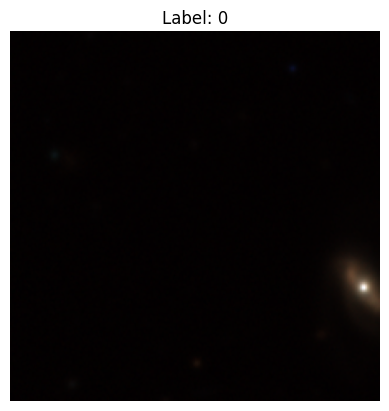

In [10]:
# Mostrar una imagen del train_loader (desnormalizada para visualización)


# Obtener un batch
images, labels = next(iter(train_loader))

# Tomar la primera imagen del batch
img_tensor = images[0]  # shape (3, H, W)

# El processor normaliza; necesitamos desnormalizar para visualizar correctamente
mean = torch.tensor(processor.image_mean).view(3, 1, 1)
std = torch.tensor(processor.image_std).view(3, 1, 1)

img_denorm = img_tensor * std + mean
img_denorm = img_denorm.clamp(0, 1)

# Convertir a HWC para matplotlib
img_np = img_denorm.permute(1, 2, 0).cpu().numpy()

plt.figure()
plt.imshow(img_np)
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")
plt.show()


In [11]:

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===== Calcular pesos =====
counts = torch.tensor(
    [class_counts["clase0"], class_counts["clase1"]],
    dtype=torch.float32
)

n_total = counts.sum()
n_classes = len(counts)

class_weights = (n_total / (n_classes * counts)).to(device)

print("Class weights:", class_weights)

# ===== Loss con pesos =====
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ===== Optimizer =====
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

num_epochs = 10

for epoch in range(num_epochs):

    # TRAIN
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=images)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss/len(val_loader):.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )



Class weights: tensor([0.5462, 5.9149], device='cuda:0')
Epoch 1/10 | Train Loss: 2.6812 | Train Acc: 0.9155 | Val Loss: 1.6096 | Val Acc: 0.9130
Epoch 2/10 | Train Loss: 2.2788 | Train Acc: 0.9155 | Val Loss: 1.4370 | Val Acc: 0.9130
Epoch 3/10 | Train Loss: 2.0925 | Train Acc: 0.9155 | Val Loss: 1.2576 | Val Acc: 0.9130
Epoch 4/10 | Train Loss: 2.0102 | Train Acc: 0.9155 | Val Loss: 1.0868 | Val Acc: 0.9130
Epoch 5/10 | Train Loss: 1.6928 | Train Acc: 0.9155 | Val Loss: 0.9368 | Val Acc: 0.9130
Epoch 6/10 | Train Loss: 1.5168 | Train Acc: 0.9155 | Val Loss: 0.8025 | Val Acc: 0.9130
Epoch 7/10 | Train Loss: 1.1145 | Train Acc: 0.9155 | Val Loss: 0.6984 | Val Acc: 0.9130
Epoch 8/10 | Train Loss: 1.0640 | Train Acc: 0.9137 | Val Loss: 0.6284 | Val Acc: 0.9130
Epoch 9/10 | Train Loss: 0.8910 | Train Acc: 0.9011 | Val Loss: 0.5958 | Val Acc: 0.8841
Epoch 10/10 | Train Loss: 0.8168 | Train Acc: 0.8363 | Val Loss: 0.5821 | Val Acc: 0.7971


In [12]:

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Modelo CNN =====
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar backbone
for param in model.parameters():
    param.requires_grad = False

# Reemplazar última capa (2 clases)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model.to(device)

# ===== Calcular class weights =====
counts = torch.tensor(
    [class_counts["clase0"], class_counts["clase1"]],
    dtype=torch.float32
)

n_total = counts.sum()
n_classes = len(counts)

class_weights = (n_total / (n_classes * counts)).to(device)

print("Class weights:", class_weights)

# ===== Loss ponderada =====
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ===== Optimizer (solo última capa) =====
optimizer = AdamW(model.fc.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):

    # =======================
    # TRAIN
    # =======================
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # =======================
    # VALIDATION
    # =======================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss/len(val_loader):.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )



Class weights: tensor([0.5462, 5.9149], device='cuda:0')
Epoch 1/10 | Train Loss: 0.7360 | Train Acc: 0.5971 | Val Loss: 0.6802 | Val Acc: 0.8116
Epoch 2/10 | Train Loss: 0.7099 | Train Acc: 0.7950 | Val Loss: 0.6940 | Val Acc: 0.6957
Epoch 3/10 | Train Loss: 0.6994 | Train Acc: 0.7788 | Val Loss: 0.6971 | Val Acc: 0.6232
Epoch 4/10 | Train Loss: 0.6800 | Train Acc: 0.6924 | Val Loss: 0.6702 | Val Acc: 0.7391
Epoch 5/10 | Train Loss: 0.6861 | Train Acc: 0.7752 | Val Loss: 0.6643 | Val Acc: 0.6957
Epoch 6/10 | Train Loss: 0.6966 | Train Acc: 0.8219 | Val Loss: 0.6528 | Val Acc: 0.7246
Epoch 7/10 | Train Loss: 0.6978 | Train Acc: 0.6583 | Val Loss: 0.6524 | Val Acc: 0.7101
Epoch 8/10 | Train Loss: 0.6998 | Train Acc: 0.7806 | Val Loss: 0.6728 | Val Acc: 0.6087
Epoch 9/10 | Train Loss: 0.6740 | Train Acc: 0.7284 | Val Loss: 0.6265 | Val Acc: 0.8696
Epoch 10/10 | Train Loss: 0.6975 | Train Acc: 0.8004 | Val Loss: 0.6427 | Val Acc: 0.6957
